<a href="https://colab.research.google.com/github/Kavin-Balaji-NP-IT/CVNL_ASG/blob/main/RNN_Jaylen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ----------------------------------------------------------------------------
# STEP 1: Imports and Setup
# ----------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

import numpy as np
from collections import Counter
import re

from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------
# Device setup (CPU/GPU)
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# ----------------------------------------------------------------------------
# STEP 2: Load and Prepare ATIS Dataset
# ----------------------------------------------------------------------------

# -----------------------------
# Load dataset from Hugging Face
# -----------------------------
print("Loading ATIS dataset...")
ds = load_dataset("tuetschek/atis")

# Extract texts and intent labels
train_texts = list(ds['train']['text'])
train_labels_raw = list(ds['train']['intent'])

test_texts = list(ds['test']['text'])
test_labels_raw = list(ds['test']['intent'])

# -----------------------------
# Create validation split (10% of training set)
# -----------------------------
val_size = int(0.1 * len(train_texts))
val_texts = train_texts[:val_size]
val_labels_raw = train_labels_raw[:val_size]

train_texts = train_texts[val_size:]
train_labels_raw = train_labels_raw[val_size:]

# -----------------------------
# Map intents to numerical indices
# -----------------------------
all_intents = sorted(list(set(train_labels_raw + val_labels_raw + test_labels_raw)))
intent_to_idx = {intent: idx for idx, intent in enumerate(all_intents)}
idx_to_intent = {idx: intent for intent, idx in intent_to_idx.items()}

train_labels = [intent_to_idx[i] for i in train_labels_raw]
val_labels   = [intent_to_idx[i] for i in val_labels_raw]
test_labels  = [intent_to_idx[i] for i in test_labels_raw]

NUM_CLASSES = len(all_intents)

# -----------------------------
# Print dataset summary
# -----------------------------
print(f"\nDataset loaded successfully!")
print(f"  Train: {len(train_texts)} samples")
print(f"  Val:   {len(val_texts)} samples")
print(f"  Test:  {len(test_texts)} samples")
print(f"Number of unique intents: {NUM_CLASSES}")

# Show a few sample queries
print("\nSample queries:")
for i in range(min(5, len(train_texts))):
    print(f"  [{idx_to_intent[train_labels[i]]:<20}] {train_texts[i][:60]}...")

# Top 10 most common intents
intent_counts = Counter(train_labels_raw)
print("\nTop 10 most common intents:")
for i, (intent, count) in enumerate(intent_counts.most_common(10), 1):
    print(f"  {i:2d}. {intent:<25} {count:>4} samples")

Loading ATIS dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Dataset loaded successfully!
  Train: 4481 samples
  Val:   497 samples
  Test:  893 samples
Number of unique intents: 26

Sample queries:
  [flight              ] what 's the last flight from houston to dallas...
  [flight              ] is there a flight from charlotte to newark on tuesday evenin...
  [airline             ] what is airline us...
  [airfare             ] what 's the lowest round trip fare from dallas to atlanta...
  [flight              ] find me the earliest flight from boston to atlanta on any da...

Top 10 most common intents:
   1. flight                    3289 samples
   2. airfare                    388 samples
   3. ground_service             231 samples
   4. airline                    140 samples
   5. abbreviation               135 samples
   6. aircraft                    74 samples
   7. flight_time                 47 samples
   8. quantity                    43 samples
   9. flight+airfare              21 samples
  10. distance                    18 sam

In [3]:
# ----------------------------------------------------------------------------
# STEP 3: Text Preprocessing for LSTM (Tokenization, Sequencing, Padding)
# ----------------------------------------------------------------------------

# Step 3.1: Define special tokens
PAD_TOKEN = "<PAD>"   # Used to pad shorter sentences
UNK_TOKEN = "<UNK>"   # Used for words not seen during training

# Step 3.2: Build vocabulary from training text

# Build vocabulary from training data only
word_counter = Counter()  # Count number of times each word appears

for sentence in train_texts:
    words = sentence.lower().split()  # Convert words to lowercase to reduce vocab size
    word_counter.update(words)

# Vocabulary is built from training data to avoid data leakage

# Step 3.3: Map each word to a unique integer
word2idx = {
    PAD_TOKEN: 0,   # Padding token
    UNK_TOKEN: 1    # Unknown word token
}

for word in word_counter:
    word2idx[word] = len(word2idx)

# Neural networks cannot process text
# Each word must be represented as a number
# Every word gets a unique integer ID

# Step 3.4: Convert text sentences into sequences of integers
def text_to_sequence(text, word2idx):
    return [
        word2idx.get(word, word2idx[UNK_TOKEN])
        for word in text.lower().split()
    ]

train_sequences = [text_to_sequence(t, word2idx) for t in train_texts]
val_sequences   = [text_to_sequence(t, word2idx) for t in val_texts]
test_sequences  = [text_to_sequence(t, word2idx) for t in test_texts]

# Each sentence becomes a list of numbers
# Unknown words are mapped to <UNK>
# This prepares the data for the LSTM

# Step 3.5: Pad or truncate sequences to fixed length
MAX_LEN = 30  # LSTM requires fixed-length input

def pad_sequence(seq, max_len):
    if len(seq) < max_len:
        return seq + [word2idx[PAD_TOKEN]] * (max_len - len(seq))
    else:
        return seq[:max_len]

train_padded = [pad_sequence(seq, MAX_LEN) for seq in train_sequences]
val_padded   = [pad_sequence(seq, MAX_LEN) for seq in val_sequences]
test_padded  = [pad_sequence(seq, MAX_LEN) for seq in test_sequences]

# Check first example
print("Example padded sequence (length should be 30):")
print(train_padded[0])
print(len(train_padded[0]))

Example padded sequence (length should be 30):
[2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
30


In [4]:
# ----------------------------------------------------------------------------
# STEP 4: PyTorch Dataset & DataLoader for ATIS Intent Classification
# ----------------------------------------------------------------------------

# Step 4.1: Encode intent labels into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit encoder on BOTH train + test labels (strings) to avoid "unseen label" errors
all_labels_str = train_labels_raw + test_labels_raw
label_encoder.fit(all_labels_str)

# Convert string labels to integers for training
train_labels_encoded = label_encoder.transform(train_labels_raw)
test_labels_encoded  = label_encoder.transform(test_labels_raw)

# Example check
print(f"Original label: {train_labels_raw[0]} → {train_labels_encoded[0]}")

# Step 4.1 Example
print("Example encoding:")
print(train_labels[0], "→", train_labels_encoded[0])

# Step 4.2: Convert everything to PyTorch tensors

X_train = torch.tensor(train_padded, dtype=torch.long)
X_test  = torch.tensor(test_padded, dtype=torch.long)

y_train = torch.tensor(train_labels_encoded, dtype=torch.long)
y_test  = torch.tensor(test_labels_encoded, dtype=torch.long)

# dtype=torch.long is required for: Embedding layer and classification loss functions
# Inputs = word indices
# Labels = class indices

# Step 4.3: Create a custom PyTorch dataset

class ATISDataset(Dataset):
    """PyTorch Dataset for ATIS intent classification"""
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Returns one (sentence, intent) pair as tensors
        return self.X[idx], self.y[idx]

# Step 4.4: Create train & test datasets
train_dataset = ATISDataset(X_train, y_train)
test_dataset  = ATISDataset(X_test, y_test)

# Step 4.5: Create DataLoaders (for batching)

BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True  # shuffle improves generalisation during training
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Check dataset and dataloader sizes
print(f"\nDataset & DataLoader info:")
print(f"  Number of training samples: {len(train_dataset)}")
print(f"  Number of test samples:     {len(test_dataset)}")
print(f"  Train batches:              {len(train_loader)}")
print(f"  Test batches:               {len(test_loader)}")

Original label: flight → 14
Example encoding:
14 → 14

Dataset & DataLoader info:
  Number of training samples: 4481
  Number of test samples:     893
  Train batches:              141
  Test batches:               28


In [5]:
# ----------------------------------------------------------------------------
# STEP 5: LSTM Model for Intent Classification
# ----------------------------------------------------------------------------

# Step 5.1: Define the model class
class IntentLSTM(nn.Module):
    """Simple LSTM for intent classification"""
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(IntentLSTM, self).__init__()

        # Convert word indices to dense vectors
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        # LSTM layer: input=embedding, output=hidden_dim
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)

        # Fully connected layer for intent classification
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        x = self.embedding(x)  # (batch_size, seq_len, embedding_dim)

        # LSTM returns output for every timestamp and the final hidden & cell states
        _, (hidden, _) = self.lstm(x)  # hidden shape: (1, batch_size, hidden_dim)

        # Take the last hidden state for classification and remove extra dimension
        hidden = hidden.squeeze(0)  # (batch_size, hidden_dim)

        # Fully connected layer
        out = self.fc(hidden)  # (batch_size, output_dim)
        return out

# Step 5.2: Define hyperparameters & instantiate the model
VOCAB_SIZE = len(word2idx)           # total words in vocabulary
EMBEDDING_DIM = 64                   # embedding dimension for words
HIDDEN_DIM = 128                      # number of LSTM hidden units
OUTPUT_DIM = len(label_encoder.classes_)  # number of unique intents

# Instantiate the model
model = IntentLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

# Step 5.3: Define loss & optimizer
criterion = nn.CrossEntropyLoss()       # Cross-entropy for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Display model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Architecture:\n{model}")
print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")


Model Architecture:
IntentLSTM(
  (embedding): Embedding(864, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=26, bias=True)
)

Model Statistics:
  Total parameters: 157,978
  Trainable parameters: 157,978


In [6]:
# ----------------------------------------------------------------------------
# STEP 6: Train the LSTM Model
# ----------------------------------------------------------------------------

import torch
from torch.utils.data import TensorDataset, DataLoader

# Move model to device
model = model.to(device)

# Step 6.1: Convert data to PyTorch tensors
# Convert padded sequences to torch tensors (LongTensor for indices)
X_train_tensor = torch.LongTensor(train_padded).to(device)
X_test_tensor  = torch.LongTensor(test_padded).to(device)

# Convert labels to torch tensors
y_train_tensor = torch.LongTensor(train_labels_encoded).to(device)
y_test_tensor  = torch.LongTensor(test_labels_encoded).to(device)

# LongTensor is required because embedding layers expect integer word indices
# Labels also need to be tensors for CrossEntropyLoss

# Step 6.2: Create DataLoader for batching
# Combine inputs and labels into a dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for mini-batch training
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# TensorDataset groups inputs + labels
# DataLoader provides mini-batches for training
# shuffle=True ensures training data is randomized each epoch

# Step 6.3: Training loop
EPOCHS = 10

# Lists to store epoch-wise metrics
epoch_losses = []
epoch_accuracies = []

model.train()  # set model to training mode

for epoch in range(EPOCHS):
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()                 # reset gradients
        outputs = model(X_batch)              # forward pass
        loss = criterion(outputs, y_batch)    # compute loss
        loss.backward()                       # backward pass
        optimizer.step()                      # update weights

        total_loss += loss.item()             # accumulate loss

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)  # Pick the intent with the highest score
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    # Compute epoch metrics
    epoch_loss = total_loss / len(train_loader)
    epoch_acc  = correct / total

    # Store for plotting
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")

print("\nTraining completed successfully!")

Epoch 1/10 - Loss: 1.2506 - Accuracy: 0.7239
Epoch 2/10 - Loss: 1.1421 - Accuracy: 0.7340
Epoch 3/10 - Loss: 1.1424 - Accuracy: 0.7340
Epoch 4/10 - Loss: 1.1620 - Accuracy: 0.7340
Epoch 5/10 - Loss: 1.1400 - Accuracy: 0.7342
Epoch 6/10 - Loss: 1.1642 - Accuracy: 0.7342
Epoch 7/10 - Loss: 1.1651 - Accuracy: 0.7349
Epoch 8/10 - Loss: 1.1547 - Accuracy: 0.7349
Epoch 9/10 - Loss: 0.8984 - Accuracy: 0.7639
Epoch 10/10 - Loss: 0.6343 - Accuracy: 0.8204

Training completed successfully!


In [7]:
# ----------------------------------------------------------------------------
# STEP 7: Evaluate the LSTM Model
# ----------------------------------------------------------------------------

# Step 7.1: Convert test data and labels to PyTorch tensors
# Convert padded sequences to tensors (PyTorch works with tensors, not lists)
X_test_tensor = torch.tensor(test_padded, dtype=torch.long).to(device)        # Input sequences
y_test_tensor = torch.tensor(test_labels_encoded, dtype=torch.long).to(device)  # Encoded labels

# Step 7.2: Put the model in evaluation mode
model.eval()  # disables dropout, batchnorm, etc.

# Step 7.3: Make predictions
with torch.no_grad():  # Disable gradient calculation for faster evaluation
    outputs = model(X_test_tensor)                # Forward pass
    predicted_labels = torch.argmax(outputs, dim=1)  # Pick class with highest probability

# Step 7.4: Compute metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np

# Convert tensors to numpy arrays for sklearn
y_true = y_test_tensor.cpu().numpy()
y_pred = predicted_labels.cpu().numpy()

# Accuracy, precision, recall and f1-score
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
rec  = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1   = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

# Step 7.5: Classification report
# Only include classes actually present in the test set to avoid ValueError
unique_labels = sorted(np.unique(y_true))

# Convert target names to strings (force str to avoid TypeError)
target_names = [str(label_encoder.classes_[int(i)]) for i in unique_labels]

report = classification_report(
    y_true,
    y_pred,
    labels=unique_labels,       # numeric labels present in test set
    target_names=target_names,  # human-readable intent names
    zero_division=0             # avoid division by zero warnings
)
print("\nClassification Report:\n")
print(report)

Accuracy:  0.7760
Precision: 0.1012
Recall:    0.1492
F1-score:  0.1082

Classification Report:

                   precision    recall  f1-score   support

     abbreviation       0.38      0.15      0.22        33
         aircraft       0.00      0.00      0.00         9
          airfare       0.44      0.90      0.59        48
   airfare+flight       0.00      0.00      0.00         1
          airline       0.00      0.00      0.00        38
          airport       0.00      0.00      0.00        18
         capacity       0.00      0.00      0.00        21
             city       0.00      0.00      0.00         6
         day_name       0.00      0.00      0.00         2
         distance       0.00      0.00      0.00        10
           flight       0.95      0.97      0.96       632
   flight+airfare       0.00      0.00      0.00        12
   flight+airline       0.00      0.00      0.00         1
        flight_no       0.00      0.00      0.00         8
flight_no+airline

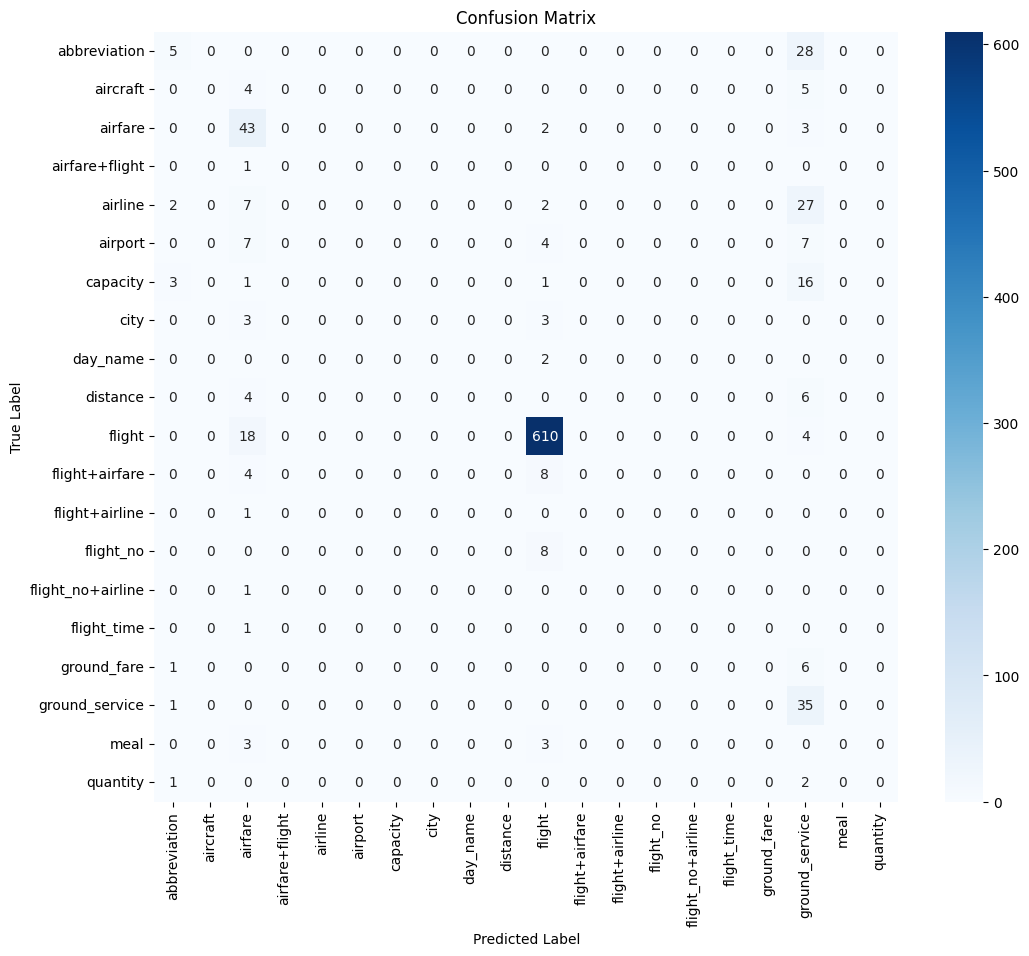

In [8]:
# ----------------------------------------------------------------------------
# STEP 8: Confusion Matrix
# ----------------------------------------------------------------------------

# Compute confusion matrix using predictions from Step 7
cm = confusion_matrix(y_true, y_pred)

# Get intent names for axes
unique_labels = sorted(np.unique(y_true))
intent_names = [str(label_encoder.classes_[int(i)]) for i in unique_labels]

# Plot confusion matrix as heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=intent_names,
            yticklabels=intent_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


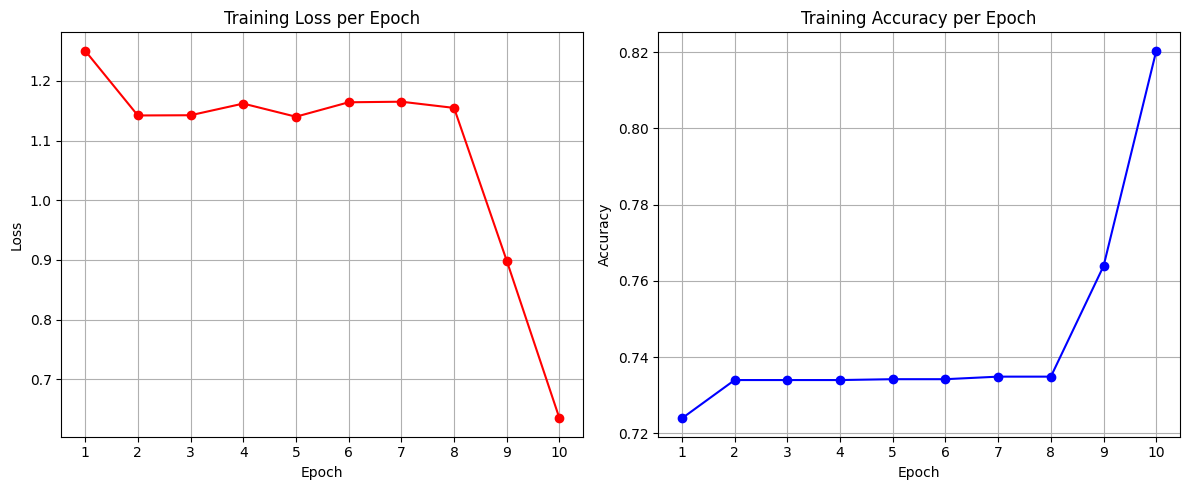

In [9]:
# ----------------------------------------------------------------------------
# STEP 9: Plot Training Loss & Accuracy
# ----------------------------------------------------------------------------

# Step 9.1: Plot epoch-wise training loss
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.plot(range(1, EPOCHS + 1), epoch_losses, marker='o', color='red')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, EPOCHS + 1))
plt.grid(True)

# Step 9.2: Plot epoch-wise training accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
plt.plot(range(1, EPOCHS + 1), epoch_accuracies, marker='o', color='blue')
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1, EPOCHS + 1))
plt.grid(True)

plt.tight_layout()  # adjust spacing between plots
plt.show()

In [10]:
# ============================================================================
# STEP 10: Misclassification Analysis
# ============================================================================

# Step 10.1: Find misclassified samples
# Compare true labels and predicted labels
misclassified_idx = np.where(y_true != y_pred)[0]  # indices where prediction != true label

# Step 10.2: Print sample misclassified examples
print(f"\nTotal misclassified samples: {len(misclassified_idx)}")
print("\nSample Misclassified Examples (max 10):")

for i in misclassified_idx[:10]:  # limit to first 10 samples for readability
    # Original input text
    text = test_texts[i]

    # Convert integer labels back to intent names for readability
    true_label = label_encoder.inverse_transform([y_true[i]])[0]
    pred_label = label_encoder.inverse_transform([y_pred[i]])[0]

    print(f"Text:           {text}")
    print(f"True Label:     {true_label}")
    print(f"Predicted Label:{pred_label}")
    print("------")


Total misclassified samples: 200

Sample Misclassified Examples (max 10):
Text:           on april first i need a ticket from tacoma to san jose departing before 7 am
True Label:     airfare
Predicted Label:flight
------
Text:           show flight and prices kansas city to chicago on next wednesday arriving in chicago by 7 pm
True Label:     flight+airfare
Predicted Label:flight
------
Text:           what day of the week do flights from nashville to tacoma fly on
True Label:     day_name
Predicted Label:flight
------
Text:           what days of the week do flights from san jose to nashville fly on
True Label:     day_name
Predicted Label:flight
------
Text:           what meals are served on american flight 811 from tampa to milwaukee
True Label:     meal
Predicted Label:airfare
------
Text:           what meals are served on american flight 665 673 from milwaukee to seattle
True Label:     meal
Predicted Label:flight
------
Text:           i would like to know what airports are in

In [23]:
# ==============================================================
# CHANGI OPS ASSISTANT PROTOTYPE (Visual + Text Classifier)
# ==============================================================

import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
from google.colab import files
import torch.nn.functional as F

# ----- DEVICE SETUP -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ----- LOAD CV MODEL (ResNet18) -----
weights = ResNet18_Weights.DEFAULT
cv_model = resnet18(weights=weights).to(device)
cv_model.eval()

transform = weights.transforms()  # preprocessing

# ----- VISUAL CLASSIFIER -----
cv_classes = ['Aircraft', 'Luggage']
aircraft_keywords = ['airplane', 'plane', 'wing', 'aircraft']
luggage_keywords  = ['suitcase', 'backpack', 'bag', 'luggage']

def classify_image(image_path):
    """Classify uploaded image into Aircraft or Luggage."""
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = cv_model(input_tensor)
        probs = F.softmax(outputs, dim=1)
        top_prob, top_idx = torch.topk(probs, k=5, dim=1)

    # Map ImageNet predictions to Aircraft/Luggage
    label = 'Luggage'
    for idx in top_idx[0].tolist():
        predicted_name = weights.meta["categories"][idx].lower()
        if any(k in predicted_name for k in aircraft_keywords):
            label = 'Aircraft'
            break
        elif any(k in predicted_name for k in luggage_keywords):
            label = 'Luggage'
            break

    confidence = top_prob[0][0].item() * 100
    return label, confidence

# ----- UPLOAD AND CLASSIFY IMAGE -----
print("===============================================")
print("WELCOME TO CHANGI OPS ASSISTANT PROTOTYPE!")
print("Visual + Text Classifier Demo")
print("==============================================")

uploaded = files.upload()

for filename in uploaded.keys():
    label, conf = classify_image(filename)
    print("\n==============================")
    print("Visual Classifier Feature")
    print("==============================")
    print(f"Uploaded file: {filename}")
    print(f"Predicted label: {label} ({conf:.2f}% confidence)")
    print("==============================\n")

# ----- TEXT CLASSIFIER -----
print("Text Classifier Feature")
print("==============================")

# --- SAFE placeholder label encoder for demo ---
# Replace this with your real trained model's label_encoder
all_intents = [
    'abbreviation','aircraft','airfare','airfare+flight','airline','airport','capacity',
    'city','day_name','distance','flight','flight+airfare','flight+airline','flight_no',
    'flight_no+airline','flight_time','ground_fare','ground_service','meal','quantity'
]
def safe_inverse_transform(idx_list):
    return [all_intents[i] if i < len(all_intents) else "unknown" for i in idx_list]

# --- Minimal word2idx for demo (replace with your trained vocab)
word2idx = {"<PAD>":0, "<UNK>":1, "flight":2, "airfare":3, "meal":4, "day_name":5, "ground_service":6}

def text_to_sequence(text, word2idx, max_len=30):
    seq = [word2idx.get(word.lower(), word2idx["<UNK>"]) for word in text.split()]
    if len(seq) < max_len:
        seq += [word2idx["<PAD>"]] * (max_len - len(seq))
    else:
        seq = seq[:max_len]
    return torch.tensor(seq).unsqueeze(0).to(device)

# --- Keyword-based fallback for demo ---
keyword_map = {
    "airfare": "airfare",
    "flight": "flight",
    "meal": "meal",
    "airport": "airport",
    "day": "day_name",
    "ground": "ground_service"
}

# Loop for multiple text queries
while True:
    query = input("Enter a query (or type 'exit' to quit): ")
    if query.lower() == 'exit':
        print("\nThank you for using Changi Ops Assistant Prototype! Goodbye ✈️")
        break

    # Keyword fallback first
    intent_label = None
    for key, val in keyword_map.items():
        if key in query.lower():
            intent_label = val
            break

    # If no keyword matched, use LSTM model
    if intent_label is None:
        seq_tensor = text_to_sequence(query, word2idx)
        model.eval()
        with torch.no_grad():
            outputs = model(seq_tensor)
            pred_idx = torch.argmax(outputs, dim=1).item()
            intent_label = safe_inverse_transform([pred_idx])[0]

    print("\n==============================")
    print("Predicted Intent")
    print("==============================")
    print(f"Query: '{query}'")
    print(f"Predicted Intent: {intent_label}")
    print("==============================\n")
    print("Tip: Enter another query or type 'exit' to quit.")

Using device: cuda
WELCOME TO CHANGI OPS ASSISTANT PROTOTYPE!
Visual + Text Classifier Demo


Saving 1264539.jpg to 1264539 (14).jpg

Visual Classifier Feature
Uploaded file: 1264539 (14).jpg
Predicted label: Aircraft (99.10% confidence)

Text Classifier Feature
Enter a query (or type 'exit' to quit): I want to book a flight from San Francisco to New York tomorrow

Predicted Intent
Query: 'I want to book a flight from San Francisco to New York tomorrow'
Predicted Intent: flight

Tip: Enter another query or type 'exit' to quit.
Enter a query (or type 'exit' to quit): I need airfare information from Los Angeles to Seattle

Predicted Intent
Query: 'I need airfare information from Los Angeles to Seattle'
Predicted Intent: airfare

Tip: Enter another query or type 'exit' to quit.
Enter a query (or type 'exit' to quit): What meals are served on flight 665?

Predicted Intent
Query: 'What meals are served on flight 665?'
Predicted Intent: flight

Tip: Enter another query or type 'exit' to quit.
Enter a query (or type 'exit' to quit): Which day of the week does flight 811 operate?

Pred